<img src = "../../Data/bgsedsc_0.jpg">

# Project: Decision trees

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ DT method(s) have been used - 25%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


# To look at
+ pruning
+ sklearn.feature_selection.RFECV
+ other kind of dimensionality reduction
+ ways to prevent overfitting
+ stacked ensemble
+ feature importance with LIME and SHAP
+ fit a simple neural network
+ log transformation of non-normally distributed numerical features

In [2]:
# Set working directory
import os
os.chdir('/Users/philine/Documents/GitHub/CML/mimic_icu_decisiontrees/')

In [90]:
# Import relevant packages
%matplotlib inline
import matplotlib.pylab as plt 

from utils.helper_functions import *

import pandas as pd
import numpy as np
from math import sqrt

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce

import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

SEED = 42

In [4]:
'''
# how to use pickle
# generate model
my_model= SVC(C=100, probability=True, gamma='scale')
my_model.fit(xtrain,ytrain)

# save model
filename = 'my_model.sav'
pickle.dump(my_model, open(filename, 'wb'))

# load the model from disk and use it
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(xtest)
'''

"\n# how to use pickle\n# generate model\nmy_model= SVC(C=100, probability=True, gamma='scale')\nmy_model.fit(xtrain,ytrain)\n\n# save model\nfilename = 'my_model.sav'\npickle.dump(my_model, open(filename, 'wb'))\n\n# load the model from disk and use it\nloaded_model = pickle.load(open(filename, 'rb'))\nloaded_model.predict_proba(xtest)\n"

In [5]:
# Starter code to load data
# Training dataset
data=pd.read_csv('data/mimic_train.csv')
data.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [6]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_los.csv')
data_test.sort_values('icustay_id').head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
4930,93535,121562,200011,56.0,82.0,71.205128,123.0,185.0,156.411765,37.0,...,2188-08-05 20:27:00,-64881.43517,EMERGENCY,Medicare,JEWISH,SINGLE,WHITE,ASTHMA;COPD EXACERBATION,49322,MICU
1052,30375,177945,200044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2135-07-07 16:13:00,-46540.62661,EMERGENCY,Medicare,CATHOLIC,WIDOWED,WHITE,HEAD BLEED,85220,SICU
3412,73241,149216,200049,54.0,76.0,64.833333,95.0,167.0,114.545455,33.0,...,2118-08-14 22:27:00,-38956.85890,EMERGENCY,Private,JEWISH,MARRIED,WHITE,HEPATIC ENCEPHALOPATHY,5722,MICU
1725,99052,129142,200063,85.0,102.0,92.560976,91.0,131.0,108.365854,42.0,...,2141-03-09 23:19:00,-47014.25437,EMERGENCY,Medicaid,NOT SPECIFIED,SINGLE,UNKNOWN/NOT SPECIFIED,TYPE A DISSECTION,44101,CSRU
981,51698,190004,200081,82.0,133.0,94.323529,86.0,143.0,111.093750,47.0,...,2142-02-23 06:56:00,-47377.26087,EMERGENCY,Medicare,OTHER,MARRIED,PORTUGUESE,PULMONARY EMBOLISM,41519,CCU


In [7]:
# Sample output prediction file
pred_sample=pd.read_csv('data/mimic_kaggle_los_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

,icustay_id,LOS
663,200011,3.701046
4608,200044,3.701046
1186,200049,3.701046
1245,200063,3.701046
606,200081,3.701046


In [8]:
# drop hospital expiry flag from columns
data.drop(columns = ['HOSPITAL_EXPIRE_FLAG'], inplace=True)
cols_diff = data.columns.difference(data_test.columns)
print(cols_diff)

Index(['LOS'], dtype='object')


## Incorporate comorbidities into the data set
For incorporating the comorbidity data I looked for a way that would retain as much information as possible, whilst not drastically increasing the dimensionality of the main dataset.
I tried the following three approaches:

1. Count the number of comorbidities of each patient
2. Make dummies for parent ICD9 categories as specified on wikipedia: https://en.wikipedia.org/wiki/List_of_ICD-9_codes. For each patient count the number of comorbidities within each parent group. Complement this with dummies for the 10 most frequent comorbidities.
3. Construct a 'mortality proxy' for each ICD9 code by combining the comorbidity data with the HOSPITAL_EXPIRE_FLAG. This yields the share of patients with a particular comorbidity who died. Calculate the mean and max probability of dying associated with the comorbidities for each patient and merge this back to the main dataset.

Approach 1 has the highest information loss. Approach 2 was an improvement on 1, but failed to account for the different severities of diseases within each parent category. I thus chose the third option, as this yielded the best results.

In [9]:
# Load comorbidity data
comorbidity = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
comorbidity.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


In [10]:
comorbidity.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [11]:
# Reformat columns
comorbidity = comorbidity.rename(columns=str.lower)
comorbidity = comorbidity.dropna()
comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


### Target encode comorbidity data with proxy for mortality

In [12]:
# Merge HOSPITAL_EXPIRE_FLAG to comorbidity dataset
comorbidity = pd.merge(left=comorbidity,
                       right=data[['subject_id', 'hadm_id', 'LOS']],
                       how='left',
                       on=['subject_id', 'hadm_id'])

comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code,LOS
0,256,108811,1.0,53240,1.7219
1,256,108811,2.0,41071,1.7219
2,256,108811,3.0,53560,1.7219
3,256,108811,4.0,40390,1.7219
4,256,108811,5.0,5859,1.7219


In [13]:
comorbidity['LOS'].describe()

count    309894.000000
mean          4.554183
std           6.289310
min           0.056600
25%           1.281700
50%           2.339900
75%           4.926800
max         101.739000
Name: LOS, dtype: float64

In [14]:
# Construct the mortality proxy for each ICD9 code
LOS_proxy = comorbidity.groupby('icd9_code')['LOS'].mean().reset_index()
LOS_proxy = LOS_proxy.rename(columns={'LOS': 'LOS_proxy', 'icd9_code': 'ICD9_diagnosis'})
LOS_proxy.head()

,ICD9_diagnosis,LOS_proxy
0,0030,3.3066
1,0031,3.7503
2,0038,3.2981
3,0039,2.9672
4,0041,0.9287


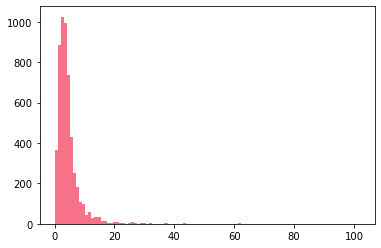

In [15]:
plt.hist(LOS_proxy['LOS_proxy'], bins=100);

In [16]:
# For each patient, compute mean and max probability of dying associated with the comorbidities
comorbidity['LOS_proxy'] = comorbidity['LOS'].groupby(comorbidity['icd9_code']).transform('mean')
comorbidity['max_LOS'] = comorbidity['LOS_proxy'].groupby(comorbidity['subject_id']).transform('max')
comorbidity['mean_LOS'] = comorbidity['LOS_proxy'].groupby(comorbidity['subject_id']).transform('mean')
comorbidity.head(10)

,subject_id,hadm_id,seq_num,icd9_code,LOS,LOS_proxy,max_LOS,mean_LOS
0,256,108811,1.0,53240,1.7219,4.263924,8.945667,4.304217
1,256,108811,2.0,41071,1.7219,4.499102,8.945667,4.304217
2,256,108811,3.0,53560,1.7219,2.736041,8.945667,4.304217
3,256,108811,4.0,40390,1.7219,3.857329,8.945667,4.304217
4,256,108811,5.0,5859,1.7219,3.895319,8.945667,4.304217
5,256,108811,6.0,04186,1.7219,3.905126,8.945667,4.304217
6,256,108811,7.0,41401,1.7219,3.397911,8.945667,4.304217
7,256,108811,8.0,2724,1.7219,3.379482,8.945667,4.304217
8,256,108811,9.0,496,1.7219,3.986099,8.945667,4.304217
9,256,108811,10.0,42731,1.7219,4.448399,8.945667,4.304217


In [17]:
comorbidity = comorbidity.drop_duplicates(subset=['subject_id', 'hadm_id'])
comorbidity.head()

,subject_id,hadm_id,seq_num,icd9_code,LOS,LOS_proxy,max_LOS,mean_LOS
0,256,108811,1.0,53240,1.7219,4.263924,8.945667,4.304217
11,256,153771,1.0,00845,NaN,6.899036,8.945667,4.304217
20,256,155415,1.0,4414,NaN,3.973953,8.945667,4.304217
26,256,188869,1.0,4413,NaN,5.560072,8.945667,4.304217
40,512,102509,1.0,V3101,NaN,NaN,4.874500,4.874500


<AxesSubplot:>

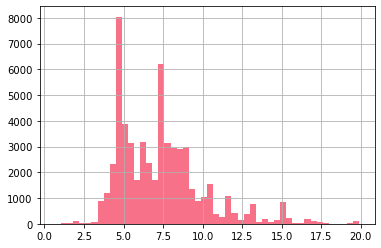

In [18]:
comorbidity.query("max_LOS < 20")['max_LOS'].hist(bins=50)

<AxesSubplot:>

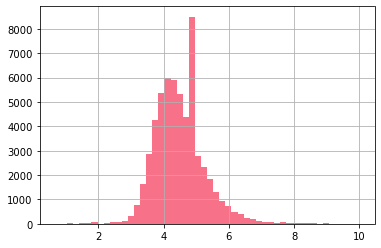

In [19]:
comorbidity.query("mean_LOS < 10")['mean_LOS'].hist(bins=50)

In [20]:
# Merge mean and max mortality from comorbidities for each patient back to main dataframe
df = pd.merge(left=data, 
                right=comorbidity[['subject_id', 'hadm_id', 'max_LOS', 'mean_LOS']],
                how='left', on=['subject_id', 'hadm_id'])

df_test = pd.merge(left=data_test, 
        right=comorbidity[['subject_id', 'hadm_id', 'max_LOS', 'mean_LOS']],
        how='left', on=['subject_id', 'hadm_id'])

print(df.shape)
print(df_test.shape)

(20885, 42)
(5221, 41)


## Data Exploration

<AxesSubplot:>

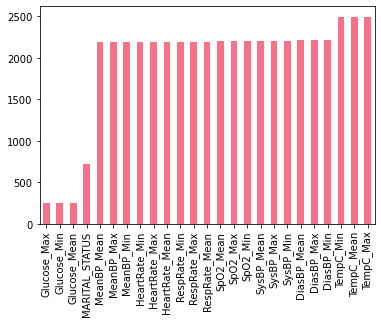

In [21]:
# look at missing values
missing = df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [22]:
cols = df.columns
cols

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS', 'max_LOS', 'mean_LOS'],
      dtype='object')

In [23]:
num_feat = df.select_dtypes(exclude=['object', 'category']).columns
num_feat = num_feat.drop(['subject_id', 'hadm_id', 'icustay_id'])
num_feat

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Diff', 'LOS', 'max_LOS', 'mean_LOS'],
      dtype='object')

In [24]:
df[num_feat].describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff,LOS,max_LOS,mean_LOS
count,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,18699.000000,...,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000,20885.000000,20885.000000,20885.000000
mean,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,56.293064,...,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830,3.701046,7.932367,4.430808
std,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,14.348780,...,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846,5.175721,3.427872,0.719098
min,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,1.000000,...,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440,0.056600,1.073000,1.073000
25%,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,49.000000,...,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110,1.165400,5.822417,3.951078
50%,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,57.000000,...,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460,2.020800,7.436406,4.337965
75%,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,64.000000,...,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030,3.915800,8.945667,4.819562
max,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,122.000000,...,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580,101.739000,101.739000,16.634612


In [28]:
# make distribution plots of numerical variables to see if log transformations are necessary

<function matplotlib.pyplot.show(close=None, block=None)>

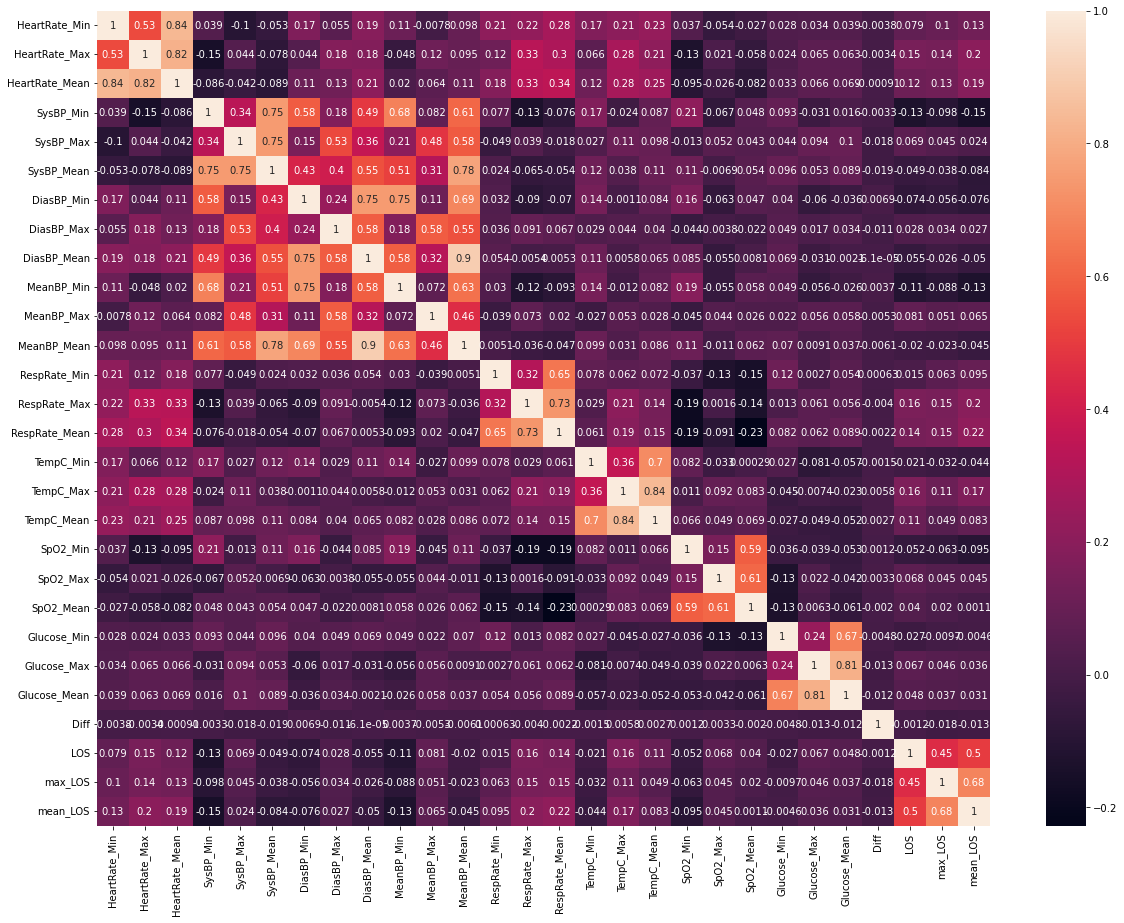

In [29]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df[num_feat].corr(), annot=True)
plt.show

In [30]:
cat_feat = df.select_dtypes(include=['object', 'category']).columns
cat_feat

Index(['GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [31]:
for col in cat_feat:
    print(df[col].value_counts())

M    11759
F     9126
Name: GENDER, dtype: int64
2117-08-07 00:00:00    26
2096-10-22 00:00:00    16
2112-11-14 00:00:00    16
2105-05-05 00:00:00    15
2144-09-28 00:00:00    15
                       ..
2097-11-11 00:00:00     1
2110-12-16 00:00:00     1
1895-07-20 00:00:00     1
2137-12-05 00:00:00     1
2143-05-24 00:00:00     1
Name: DOB, Length: 14007, dtype: int64
2165-02-25 11:40:00    5
2150-11-03 22:05:00    5
2169-10-31 20:11:00    5
2177-04-13 17:36:00    4
2176-02-27 17:39:00    4
                      ..
2170-06-03 20:01:00    1
2122-05-22 15:15:00    1
2170-01-19 22:02:00    1
2150-06-19 03:23:00    1
2189-02-19 07:15:00    1
Name: ADMITTIME, Length: 19714, dtype: int64
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER     

## Feature Manipulation

### Make an Age variable
The age variable is created using the DOB and ADMITTIME variables. I subtract the difference given by the Diff column in order to get dates that have a real meaning. Then I calculate the time difference between these two dates in order to determine the age of an individual. Note that individuals older than 89 are encoded as 300. We thus have observations with age>300. I recode these to age=90.

In [32]:
import datetime as dt

for my_df in [df, df_test]:
# Convert admittime to date, adding "Diff" to make the dates realistic
    my_df['ADMITTIME'] = (pd.to_datetime(my_df['ADMITTIME']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert dob to date, adding "Diff" to make the dates realistic
    my_df['DOB'] = (pd.to_datetime(my_df['DOB']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert to age in years
    my_df['age'] = my_df.apply(lambda e: (e['ADMITTIME'] - e['DOB']).days/365, axis=1)
    
# Delete variables related to age
df = df.drop(columns=['DOB', 'Diff'])
df_test = df_test.drop(columns=['DOB', 'Diff'])

<AxesSubplot:xlabel='age', ylabel='Count'>

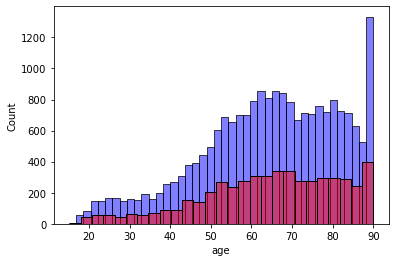

In [40]:
# Plot distribution of age
sns.histplot(data=df, x="age", color="blue", alpha=0.5)
sns.histplot(data=df_test, x="age", color="red", alpha=0.5)

In [34]:
df['age'].where(df['age'] < 89, 90, inplace=True)
df_test['age'].where(df_test['age'] < 89, 90, inplace=True)

<AxesSubplot:xlabel='age', ylabel='Count'>

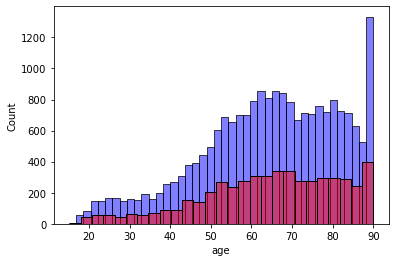

In [41]:
sns.histplot(data=df, x="age", color="blue", alpha=0.5)
sns.histplot(data=df_test, x="age", color="red", alpha=0.5)

### Religion
I use the largest religious groups in the dataset for the creation of my dummy variables and group all remaining religions in an 'Other' category. 'Unobtainable' and 'Not specified' are grouped together. The following dummies will be created: Catholic, Protestant, Jewish, Not Specified, Other.

In [42]:
df['RELIGION'].replace({"UNOBTAINABLE": "NOT SPECIFIED", "PROTESTANT QUAKER": "PROTESTANT", "HEBREW": "JEWISH"}, inplace=True)
df_test['RELIGION'].replace({"UNOBTAINABLE": "NOT SPECIFIED", "PROTESTANT QUAKER": "PROTESTANT", "HEBREW": "JEWISH"}, inplace=True)

religion_other = ["EPISCOPALIAN",
                  "GREEK ORTHODOX",
                  "CHRISTIAN SCIENTIST",
                  "BUDDHIST",
                  "MUSLIM",
                  "UNITARIAN-UNIVERSALIST",
                  "JEHOVAH'S WITNESS",
                  "HINDU",
                  "ROMANIAN EAST. ORTH",
                  "7TH DAY ADVENTIST"]

for religion in religion_other:
    df['RELIGION'].replace({religion: "OTHER"}, inplace=True)
    df_test['RELIGION'].replace({religion: "OTHER"}, inplace=True)

df['RELIGION'].value_counts()
df_test['RELIGION'].value_counts()

CATHOLIC         1898
NOT SPECIFIED    1756
PROTESTANT        697
JEWISH            446
OTHER             424
Name: RELIGION, dtype: int64

### Ethnicity
I merge ethnicities into the "main" ethnic groups. These include: White, Black, Hispanic and Asian.
All other ethnic groups are put into an 'Other' column unless the ethnicity is not specified.

In [43]:
for my_df in [df, df_test]:
    my_df.loc[my_df['ETHNICITY'].str.contains('WHITE', case=False), 'ETHNICITY'] = 'WHITE'
    my_df.loc[my_df['ETHNICITY'].str.contains('HISPANIC', case=False), 'ETHNICITY'] = 'HISPANIC'
    my_df.loc[my_df['ETHNICITY'].str.contains('ASIAN', case=False), 'ETHNICITY'] = 'ASIAN'
    my_df.loc[my_df['ETHNICITY'].str.contains('BLACK', case=False), 'ETHNICITY'] = 'BLACK'

    my_df['ETHNICITY'].replace({'PORTUGUESE': "WHITE"}, inplace=True)

    unknowns = ['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER']
    for unknown in unknowns:
        my_df['ETHNICITY'].replace({unknown: "UNKNOWN/NOT SPECIFIED"}, inplace=True)

    ethnicity_other = ['MULTI RACE ETHNICITY',
                      'MIDDLE EASTERN', 
                      'AMERICAN INDIAN/ALASKA NATIVE',
                      'CARIBBEAN ISLAND',
                      'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                      'SOUTH AMERICAN',
                      'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']
    for ethnicity in ethnicity_other:
        my_df['ETHNICITY'].replace({ethnicity: "OTHER"}, inplace=True)
    
df['ETHNICITY'].value_counts()
df_test['ETHNICITY'].value_counts()

WHITE                    3866
BLACK                     532
UNKNOWN/NOT SPECIFIED     352
HISPANIC                  203
ASIAN                     144
OTHER                     124
Name: ETHNICITY, dtype: int64

### Repeat Visits to the ICU
Some patients visit the ICU more than once. I capture this in a variable.

In [44]:
df['visits_ICU'] = df.sort_values(['subject_id', 'ADMITTIME']).groupby(['subject_id']).cumcount()
df_test['visits_ICU'] = df_test.sort_values(['subject_id', 'ADMITTIME']).groupby(['subject_id']).cumcount()

In [45]:
df[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]
df_test[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]

,subject_id,ADMITTIME,visits_ICU
1763,107,2011-07-01,0
2871,107,2011-12-13,1
2929,109,2008-05-18,0
125,109,2008-11-24,1
4617,109,2008-12-15,2
569,109,2009-04-26,3
1170,154,2011-07-11,0
3654,188,2011-05-12,0
3997,236,2009-01-08,0
2423,249,2009-09-17,0


In [46]:
# Delete 'ADMITTIME'
df = df.drop(columns=['ADMITTIME'])
df_test = df_test.drop(columns=['ADMITTIME'])

### Diagnoses
I remove the text fields. The ICD9-codes will be target encoded (with smoothing) in the pipeline.

In [47]:
df = df.drop(['DIAGNOSIS'], axis = 1)
df_test = df_test.drop(['DIAGNOSIS'], axis = 1)

### Drop all remaining unnecessary columns

In [48]:
# Drop id columns
df = df.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
df_test = df_test.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
print(df.columns)
print(df_test.columns)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'ICD9_diagnosis', 'FIRST_CAREUNIT',
       'LOS', 'max_LOS', 'mean_LOS', 'age', 'visits_ICU'],
      dtype='object')
Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER'

## Preprocessing
Initially, I wanted to set up a preprocessing pipeline. Unfortunately, I lost the feature names in the process. I will thus manually preprocess the data. I have kept the code for setting up the preprocessing pipeline as this yields a nice depiction of how each group of features is manipulated.

In [49]:
# Update list of numerical and categorical features
num_feat_clean = df.select_dtypes(exclude=['object', 'category']).columns
num_feat_clean = num_feat_clean.drop(['LOS'])
print(num_feat_clean)

cat_feat_clean = df.select_dtypes(include=['object', 'category']).columns
print(cat_feat_clean)

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat_clean = ['ICD9_diagnosis']
cat_feat_clean = cat_feat_clean.drop(['ICD9_diagnosis']) 
print(icd9_feat_clean)
print(cat_feat_clean)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'max_LOS', 'mean_LOS', 'age', 'visits_ICU'],
      dtype='object')
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'ICD9_diagnosis', 'FIRST_CAREUNIT'],
      dtype='object')
['ICD9_diagnosis']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


In [50]:
# pipeline for numerical data
num_preprocessing = make_pipeline(
    RobustScaler(),
    SimpleImputer(strategy="mean"))

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
    StandardScaler())

icd9_preprocessing = make_pipeline(
    #ce.BinaryEncoder(),
    ce.TargetEncoder(smoothing = 1.0),
    StandardScaler())


# combine preprocessing pipelines using a columnTransformer
preprocessing= ColumnTransformer(
    [("num", num_preprocessing, num_feat_clean),
     ("cat", cat_preprocessing, cat_feat_clean),
     ("icd9", icd9_preprocessing, icd9_feat_clean)],
     remainder='passthrough'
)

In [51]:
from sklearn import set_config
set_config(display="diagram")
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max',...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')),
                                ('icd9',
                                 Pipeline(steps=[('targetencoder',
                                                  TargetEncoder()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['ICD9_diagnosis'])])

In [52]:
## preprocess numerical features
# scale data
df[num_feat_clean] = RobustScaler().fit_transform(df[num_feat_clean])
df_test[num_feat_clean] = RobustScaler().fit_transform(df_test[num_feat_clean])

# impute missing values
df[num_feat_clean] = SimpleImputer(strategy="mean").fit_transform(df[num_feat_clean])
df_test[num_feat_clean] = SimpleImputer(strategy="mean").fit_transform(df_test[num_feat_clean])

# check that preprocessing worked
df[num_feat_clean].describe()
#df[num_feat_clean].isnull().sum().sort_values()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,max_LOS,mean_LOS,age,visits_ICU
count,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,...,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000,20885.000000
mean,0.037153,0.079993,0.050164,0.055528,0.090864,0.100311,0.023418,0.102643,0.077691,-0.047129,...,-0.248127,-0.444117,-0.109002,0.136628,0.264120,0.232491,0.158797,0.106902,-0.059705,0.395547
std,0.740512,0.707029,0.693065,0.828991,0.751289,0.706187,0.804455,0.792917,0.743537,0.905137,...,1.749561,1.096916,0.870925,0.999002,1.151282,1.018973,1.097534,0.827992,0.692698,1.118684
min,-3.526316,-2.285714,-2.362991,-4.250000,-3.400000,-3.170203,-2.857143,-2.565217,-3.172304,-3.733333,...,-22.750000,-43.000000,-19.527605,-2.857143,-1.487500,-1.977401,-2.037431,-3.759381,-2.047856,0.000000
25%,-0.421053,-0.392857,-0.409533,-0.400000,-0.400000,-0.387596,-0.428571,-0.434783,-0.405157,-0.466667,...,-0.500000,-0.444117,-0.451071,-0.428571,-0.425000,-0.403086,-0.516766,-0.445474,-0.500055,0.000000
50%,0.037153,0.079993,0.050164,0.055528,0.090864,0.100311,0.023418,0.086957,0.077691,-0.047129,...,0.000000,0.000000,-0.109002,0.000000,0.000000,0.007605,0.000000,0.000000,0.000000,0.000000
75%,0.473684,0.464286,0.453065,0.500000,0.466667,0.479584,0.428571,0.434783,0.455336,0.400000,...,0.500000,0.000000,0.417240,0.542857,0.550000,0.580291,0.483234,0.554526,0.499945,0.000000
max,3.789474,6.321429,3.813147,4.550000,5.833333,3.812654,4.357143,9.043478,4.289306,4.333333,...,2.000000,0.000000,1.127677,13.171429,28.487500,14.676119,30.193744,14.158736,0.982165,24.000000


In [53]:
## preprocess categorical features
# impute missing values
df[cat_feat_clean] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_feat_clean])
df_test[cat_feat_clean] = SimpleImputer(strategy="most_frequent").fit_transform(df_test[cat_feat_clean])

# get dummies
df = pd.get_dummies(df, columns = cat_feat_clean, drop_first=True)
df_test = pd.get_dummies(df_test, columns = cat_feat_clean, drop_first=True)

In [54]:
# update list of categorical features
cat_feat_dummies = ['GENDER_M', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Medicaid',
                'INSURANCE_Medicare','INSURANCE_Private', 'INSURANCE_Self Pay', 'RELIGION_JEWISH',
                'RELIGION_NOT SPECIFIED', 'RELIGION_OTHER', 'RELIGION_PROTESTANT','MARITAL_STATUS_LIFE PARTNER',
                'MARITAL_STATUS_MARRIED','MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE',
                'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_BLACK',
                'ETHNICITY_HISPANIC', 'ETHNICITY_OTHER','ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_WHITE',
                'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU']

# scale data
df[cat_feat_dummies] = StandardScaler().fit_transform(df[cat_feat_dummies])
df_test[cat_feat_dummies] = StandardScaler().fit_transform(df_test[cat_feat_dummies])

# check that preprocessing worked
df[cat_feat_dummies].describe()
#df[cat_feat_dummies].isnull().sum().sort_values()

,GENDER_M,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_URGENT,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,RELIGION_JEWISH,RELIGION_NOT SPECIFIED,RELIGION_OTHER,...,MARITAL_STATUS_WIDOWED,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_OTHER,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU
count,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,...,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04
mean,-3.184854e-16,-2.092588e-15,-1.647792e-17,1.447197e-15,-8.323191e-16,-9.170968e-16,-1.042041e-15,-2.200092e-15,3.471381e-16,-9.334751e-16,...,1.107294e-15,7.504066e-16,-3.226743e-16,-4.981252e-17,-1.038389e-15,9.952510e-16,3.631017e-16,-4.586547e-17,3.535012e-16,-3.131589e-17
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-1.135128e+00,-2.409848e+00,-1.031796e-01,-3.358547e-01,-1.130611e+00,-6.531241e-01,-9.683004e-02,-3.109194e-01,-7.034026e-01,-2.998625e-01,...,-3.950177e-01,-3.432220e-01,-2.062276e-01,-1.715408e-01,-2.597449e-01,-1.669414e+00,-4.196304e-01,-8.399965e-01,-4.837833e-01,-3.808031e-01
25%,-1.135128e+00,4.149640e-01,-1.031796e-01,-3.358547e-01,-1.130611e+00,-6.531241e-01,-9.683004e-02,-3.109194e-01,-7.034026e-01,-2.998625e-01,...,-3.950177e-01,-3.432220e-01,-2.062276e-01,-1.715408e-01,-2.597449e-01,-1.669414e+00,-4.196304e-01,-8.399965e-01,-4.837833e-01,-3.808031e-01
50%,8.809577e-01,4.149640e-01,-1.031796e-01,-3.358547e-01,8.844777e-01,-6.531241e-01,-9.683004e-02,-3.109194e-01,-7.034026e-01,-2.998625e-01,...,-3.950177e-01,-3.432220e-01,-2.062276e-01,-1.715408e-01,-2.597449e-01,5.990124e-01,-4.196304e-01,-8.399965e-01,-4.837833e-01,-3.808031e-01
75%,8.809577e-01,4.149640e-01,-1.031796e-01,-3.358547e-01,8.844777e-01,1.531103e+00,-9.683004e-02,-3.109194e-01,1.421661e+00,-2.998625e-01,...,-3.950177e-01,-3.432220e-01,-2.062276e-01,-1.715408e-01,-2.597449e-01,5.990124e-01,-4.196304e-01,1.190481e+00,-4.837833e-01,-3.808031e-01
max,8.809577e-01,4.149640e-01,9.691843e+00,2.977478e+00,8.844777e-01,1.531103e+00,1.032737e+01,3.216268e+00,1.421661e+00,3.334861e+00,...,2.531532e+00,2.913566e+00,4.849011e+00,5.829515e+00,3.849931e+00,5.990124e-01,2.383050e+00,1.190481e+00,2.067041e+00,2.626029e+00


In [55]:
## preprocess ICD9 codes
# target encode
encode_icd9 = ce.TargetEncoder(cols=icd9_feat_clean, smoothing = 1.0)
encode_icd9 = encode_icd9.fit(df[icd9_feat_clean], df['LOS'])

df = pd.concat([df.drop(columns=icd9_feat_clean), encode_icd9.transform(df[icd9_feat_clean])], axis=1)
df_test = pd.concat([df_test.drop(columns=icd9_feat_clean), encode_icd9.transform(df_test[icd9_feat_clean])], axis=1)

# scale
df[icd9_feat_clean] = StandardScaler().fit_transform(df[icd9_feat_clean])
df_test[icd9_feat_clean] = StandardScaler().fit_transform(df_test[icd9_feat_clean])

In [56]:
df.head()
df_test.head()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_OTHER,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_MICU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,ICD9_diagnosis
0,-0.578947,-0.500000,0.060044,-0.65,0.166667,-0.828431,-0.285714,-0.347826,-0.637796,-0.266667,...,-0.336834,-0.201133,-0.155974,-0.268876,0.592023,2.335304,-0.858069,-0.476776,-0.356252,-0.248214
1,1.157895,1.464286,1.450336,-0.85,-0.166667,-0.705426,-0.142857,0.043478,0.318696,-0.466667,...,-0.336834,-0.201133,-0.155974,-0.268876,0.592023,-0.428210,1.165408,-0.476776,-0.356252,-0.962517
2,1.947368,1.000000,1.575998,0.15,-0.366667,-0.026467,0.500000,-0.391304,0.398029,0.200000,...,-0.336834,-0.201133,-0.155974,-0.268876,0.592023,-0.428210,1.165408,-0.476776,-0.356252,-1.185883
3,0.157895,0.035714,-0.015405,-0.90,0.666667,0.460175,-0.357143,0.608696,0.126533,-0.733333,...,-0.336834,-0.201133,-0.155974,-0.268876,0.592023,-0.428210,-0.858069,-0.476776,-0.356252,-0.069370
4,0.842105,0.714286,0.682892,-0.20,-0.133333,-0.277738,0.571429,2.086957,0.830375,0.600000,...,-0.336834,-0.201133,-0.155974,-0.268876,0.592023,-0.428210,1.165408,-0.476776,-0.356252,2.832969


In [57]:
X_train, y_train = df.drop(columns=['LOS']), df['LOS']
X_test = df_test

In [58]:
y_train.describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

In [59]:
'''
# fit ColumnTransformer to preprocess the data
preprocessing.fit(X_train, y_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)
'''

'\n# fit ColumnTransformer to preprocess the data\npreprocessing.fit(X_train, y_train)\nX_train = preprocessing.transform(X_train)\nX_test = preprocessing.transform(X_test)\n'

## Simple Decision Tree Regressor
I fit a simple decision tree to have a baseline model to which compare all subsequent models too. The number of leaf nodes is limited to 20 to prevent the tree from going all the way to the end and perfectly fitting the training data.

In [60]:
%%time

dt_simple = DecisionTreeRegressor(max_leaf_nodes=20)
dt_simple.fit(X_train, y_train)

y_pred_train_dt_simple = dt_simple.predict(X_train)
y_pred_test_dt_simple = dt_simple.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_dt_simple))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_dt_simple)))

RMSE : 4.098289824630388
R-squared : 0.3729757071452533
CPU times: user 148 ms, sys: 4.57 ms, total: 153 ms
Wall time: 153 ms


In [61]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_dt_simple})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_dt_simple.csv", index = False)

## Simple Random Forest Regressor
I do the same with a simple random forest model to show that just by making an ensemble of decision trees, we can increase the perfomance of our model whilst also reducing the risk of overfitting. The RMSE decreases from 4.098 to 1.618. When uploading this model to kaggle, I only obtain a score of 4.40. This indicates that using the Random Forest has not prevented me from overfitting to the training data. The out-of-sample performance is much worse.

In [62]:
%%time

rf_simple = RandomForestRegressor(n_estimators=50)
rf_simple.fit(X_train, y_train)

y_pred_train_rf_simple = rf_simple.predict(X_train)
y_pred_test_rf_simple = rf_simple.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_rf_simple))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_rf_simple)))

RMSE : 1.6027894193073922
R-squared : 0.9040970502783278
CPU times: user 15.7 s, sys: 51.2 ms, total: 15.7 s
Wall time: 15.7 s


In [63]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_rf_simple})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_rf_simple.csv", index = False)

## Hyperparameter Optimisation and Boosting
After having fitted a simple baseline model for Decision Trees and Random Forests respectively, I try different boosting methods and contrast these with the performance of the previous two models. I perform hyperparameter optimization before I compare the in-sample performance.

In [ ]:
%%time

# models
models = [DecisionTreeRegressor(),
          RandomForestRegressor(),
          XGBRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()]

# models parameters
dt_params = {'max_features': range(4, 10),
             'max_depth': range(3, 6),
             'min_samples_leaf': range(5, 10),
             'random_state': [SEED]}

rf_params = {'max_features': range(4, 10),
             'n_estimators': [50, 100],
             'max_depth': range(3, 6),
             'min_samples_leaf': range(5, 10),
             'random_state': [SEED]}

xgb_params = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 1],
              'max_depth': range(3, 10),
              'min_child_weight': range(5, 10),
              'reg_lambda':[1.5],
              'seed': [SEED]}

ada_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'loss':['linear', 'square'],
              'random_state': [SEED]}

gbm_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'max_depth': range(3, 6),
              'max_features': range(4, 10),
              'random_state': [SEED]}

params = [dt_params, rf_params, xgb_params, ada_params, gbm_params]
names = ['dt_regressor', 'rf_regressor', 'xgb_regressor', 'ada_regressor', 'gbm_regressor']

scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    
    best_model = GridSearchCV(model, params[i], n_jobs=4, cv=5, scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    
    print(f"Best model fitted")
    
    # assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    scores[names[i]] = (best_model.best_estimator_, sqrt(-best_model.best_score_))
    
    # print scores (on LOS)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} in-sample RMSE: {sqrt(-best_model.best_score_)}')

In [ ]:
ranking = pd.DataFrame.from_dict(scores, orient='index').reset_index()
ranking.columns = ['Model', 'Setting', 'RMSE']

ranking.head()

In [ ]:
ranking = ranking.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("In-sample performance", fontsize=25)
sns.barplot(x="RMSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

The XGBoost and Gradient Boost perform best with RMSEs of 4.1216 and 4.1244 respectively.

In [ ]:
# check feature importance of the two best performing models
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center')
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [ ]:
feature_names = X_train.columns

In [ ]:
xgb_opt = models[0].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), feature_names)

In [ ]:
gb_opt = models[2].fit(X_train, y_train)
feat_indexes_gb = feature_imp(abs(gb_opt.feature_importances_), feature_names)

In [ ]:
# save best model
boost_best_model = ranking.Setting[0].fit(X_train, y_train)

file = 'pickles/boost_best.sav'
pickle.dump(boost_best_model, open(file, 'wb'))

In [ ]:
# load the model from disk and use it
boost_best_pickled = pickle.load(open('pickles/grid_rf.sav', 'rb'))

y_pred_train_boost = boost_best_pickled.predict(X_train)
y_pred_test_boost = boost_best_pickled.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_boost))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_boost)))

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_boost})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_boost.csv", index = False)

## Other Ensemble Methods
Having seen that boosting improves the model performance, I now apply ensemble methods that combine different regression models to determine whether this further improves the RMSE. 

In [83]:
%%time

# try out simple classifiers and see how they perform individually
models = [LinearRegression(),
          KNeighborsRegressor(n_neighbors=5),
          DecisionTreeRegressor(max_leaf_nodes=20),
          RandomForestRegressor(n_estimators=50),
          SVR()]

names = ['Linear', 'KNN', 'DecisionTree', 'RandomForest', 'SVR']
scores = {}
predicted_LOS = {}

for i, model in enumerate(models):
    print(f"Fitting model {names[i]}...")
    
    model.fit(X_train, y_train)
    print(f"Best model fitted")
    
    y_train_hat = model.predict(X_train)
    predicted_LOS[names[i]] = y_train_hat
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    
    # save model and in-sample rmse to dictionary
    scores[names[i]] = (model, rmse)
    print(f'{names[i]} in-sample RMSE: {rmse}')

Fitting model Linear...
Best model fitted
Linear in-sample RMSE: 4.265749457080908
Fitting model KNN...
Best model fitted
KNN in-sample RMSE: 3.805382224343926
Fitting model DecisionTree...
Best model fitted
DecisionTree in-sample RMSE: 4.098289824630388
Fitting model RandomForest...
Best model fitted
RandomForest in-sample RMSE: 1.6188066723159127
Fitting model SVR...
Best model fitted
SVR in-sample RMSE: 4.400140868373647
CPU times: user 1min 16s, sys: 4.78 s, total: 1min 21s
Wall time: 1min 13s


In [84]:
predicted_LOS

{'Linear': array([ 2.52760771, -0.49950067,  5.46699781, ...,  1.09505659,
         2.23564393,  4.33505105]),
 'KNN': array([3.17744, 0.87554, 3.53812, ..., 1.45072, 2.51684, 2.87204]),
 'DecisionTree': array([2.77711654, 1.8050784 , 4.70928981, ..., 1.8050784 , 2.77711654,
        2.77711654]),
 'RandomForest': array([4.1294  , 0.770202, 4.396932, ..., 1.924634, 2.686112, 2.092764]),
 'SVR': array([2.87286834, 0.80557748, 3.82324637, ..., 1.78308938, 1.77428474,
        2.49556259])}

In [85]:
# look at correlation between models
predicted_LOS = pd.DataFrame.from_dict(predicted_LOS)
predicted_LOS.head()

,Linear,KNN,DecisionTree,RandomForest,SVR
0,2.527608,3.17744,2.777117,4.129400,2.872868
1,-0.499501,0.87554,1.805078,0.770202,0.805577
2,5.466998,3.53812,4.709290,4.396932,3.823246
3,5.328125,4.67390,1.805078,3.572490,3.773757
4,5.532535,3.07984,4.709290,6.242216,3.651156


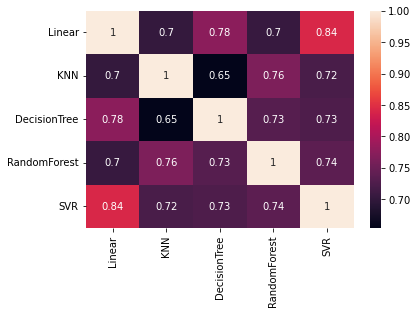

In [86]:
sns.heatmap(predicted_LOS.corr(), annot=True)
plt.show()

Correlations between the different regression models are less than 1. I can thus combine them in an ensemble to try and increase the predictive power of my model.

### Stacking

In [ ]:
meta_learners = [
    ExtraTreesRegressor(n_estimators=100, max_features=0.5, bootstrap=True, random_state=SEED),
    RandomForestRegressor(n_estimators=100, max_features=0.5, bootstrap=True, random_state=SEED),
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=SEED)
]

meta_learners_ = ['ExtraTrees', 'RandomForest', 'GradientBoosting']

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models)
    super_learner.add_meta(meta_learner)
    super_learner.fit(X_train, y_train)

    y_train_hat = super_learner.predict(X_train)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    
    scores[f'Stacking{meta_learners_[i]}'] = (super_learner, rmse)
    print(f'Super Learner with {meta_learners_[i]} in-sample RMSE: {rmse}')

### Stacking with Feature Propagation

### Blending

In [64]:
# get a stacking ensemble of models
ensemble_models = {
    "stacking": StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
}

def get_ensemble(stacking_model):
    # define the base models
    level0 = list()
    level0.append(('knn', KNeighborsRegressor()))
    level0.append(('dt', DecisionTreeRegressor()))
    level0.append(('svm', SVR()))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = ensemble_model
    #model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LinearRegression()
    models['knn'] = KNeighborsRegressor()
    models['dt'] = DecisionTreeRegressor()
    models['svm'] = SVR()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

In [69]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = (evaluate_model(model, X_train, y_train))
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>lr -2.482 (0.069)
>knn -2.460 (0.086)
>dt -3.088 (0.126)


KeyboardInterrupt: 

In [ ]:
ranking = list(zip(names,np.mean(-scores)))
ranking = pd.DataFrame(ranking, columns=['Model','MSE'])

ranking = ranking.sort_values(by='MSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle("Performance on test set", fontsize=25)
sns.barplot(x="MSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r')

In [ ]:
# Fit best model to data set
ensembles_best_model = ranking.Setting[0].fit(X_train, y_train)

# save model
file = 'pickles/boost_best.sav'
pickle.dump(boost_best_model, open(file, 'wb'))